In [19]:
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
import pandas as pd

Hello team


In [20]:
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, Model 
from keras import layers
from keras.layers import Conv2D,MaxPooling2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Dense, Flatten, Input, AveragePooling2D
from keras.optimizers import SGD, adam
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

In [21]:
INPUT_DIR = os.path.join('/kaggle', 'input', 'evohackaton')
TRAIN_DIR = os.path.join(INPUT_DIR, 'train', 'train')
TRAIN_CSV = os.path.join(INPUT_DIR, 'train.csv')
TEST_DIR = os.path.join(INPUT_DIR, 'test', 'test')
WEIGHT_DIR = os.path.join('/kaggle', 'input', 'InceptionResNetV2')

In [22]:
os.listdir('/kaggle/input')

['evohackaton', 'inceptionresnetv2']

In [79]:
os.remove('new_weights_01_0.59.hdf5')
import shutil

##shutil.rmtree('image_data')

In [24]:
print(len(os.listdir(TRAIN_DIR)))

16857


In [25]:
print(len(os.listdir(TEST_DIR)))

16858


In [26]:
train_set = pd.read_csv(TRAIN_CSV)

In [27]:
train_set.head()

,name,category
0,0.jpg,47
1,1.jpg,60
2,2.jpg,79
3,3.jpg,84
4,4.jpg,81


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb4a58f3908>]],
      dtype=object)

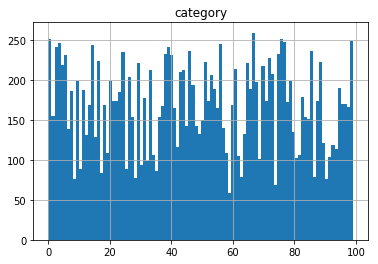

In [28]:
train_set.hist(bins=100)

In [29]:
train_set.set_index('name')
train_set['category'] = train_set['category'].astype(str)

In [45]:
categories = train_set.to_dict()
categories = categories[list(categories.keys())[0]]

In [46]:
from shutil import copyfile
from tqdm.auto import tqdm
def check_path(path):
    os.system("if [ ! -d " + path + " ]; then mkdir -p " + path + "; fi")
def make_cat(categories,train_path,output_path):
    check_path(output_path)
    for key in tqdm(categories.keys()):
        check_path(output_path+str(key))
        for pict_name in categories[key]:
            try:
                copyfile(train_path+pict_name, output_path+str(key)+"/"+pict_name)
            except Exception as e:
                print("Problem with ", train_path+pict_name)
                print(e)

In [30]:
train_df, validation_df = train_test_split(train_set, test_size=0.2)

print(f'train_df: {train_df.shape}')
print(f'validation_df: {validation_df.shape}')

train_df: (13485, 2)
validation_df: (3372, 2)


In [47]:
categories_train = train_df.groupby(['category'])['name'].apply(lambda grp: list(grp)).to_dict()
categories_val = validation_df.groupby(['category'])['name'].apply(lambda grp: list(grp)).to_dict()

In [49]:
train_path = "/kaggle/input/evohackaton/train/train/"
output_train_path = "image_data/train/"
output_val_path = "image_data/val/"

make_cat(categories_train,train_path,output_train_path)
make_cat(categories_val,train_path,output_val_path)

In [50]:
def img_array(path):
    image = img.open(path)
    tmp = np.array(image)
    image.close()
    return tmp
  
import Augmentor
from Augmentor import Pipeline

def augmentation(path, n):
    p = Augmentor.Pipeline(path) # ensure you press enter after this, don't just c&p this code.
    Pipeline.set_seed(100)
    p.rotate(probability=0.3, max_left_rotation=3, max_right_rotation=3)
    p.random_distortion(probability=0.9, grid_width=20, grid_height=20, magnitude=2)
    p.random_erasing(probability=0.5, rectangle_area=0.2)
    p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
    p.sample(n)

path = output_train_path

for i in range(100):
    augmentation(path+str(i)+'/', 400 - len(categories_train[str(i)]))

ModuleNotFoundError: No module named 'Augmentor'

In [31]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=15,
    height_shift_range=0.1,
    width_shift_range=0.1,
    shear_range=0.01,
    zoom_range=[0.9, 1.2],
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='reflect')

validation_datagen = ImageDataGenerator(
    rescale = 1./255)

In [32]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=TRAIN_DIR,
        x_col='name',
        y_col='category',
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=validation_df,
        directory=TRAIN_DIR,
        x_col='name',
        y_col='category',
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')

Found 13485 validated image filenames belonging to 100 classes.
Found 3372 validated image filenames belonging to 100 classes.


## InceptionResNetV2

In [52]:
input_shape = (256,256,3)
batch_size = 32
n_classes = 100

# Set up model
base_model = InceptionResNetV2(weights='/kaggle/input/inceptionresnetv2/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_tensor=Input(shape=input_shape))
x = base_model.output
x = AveragePooling2D(pool_size=(6, 6))(x)
x = Dropout(.4)(x)
x = Flatten()(x)
predictions = Dense(100, init='glorot_uniform', W_regularizer=l2(.0005), activation='softmax')(x)
model = Model(input=base_model.input, output=predictions)
# Display model
model.summary()

# Show if GPU is avialable
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, activation="softmax", kernel_initializer="glorot_uniform", kernel_regularizer=<keras.reg...)`
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if sys.path[0] == '':


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_407 (Conv2D)             (None, 127, 127, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_407 (BatchN (None, 127, 127, 32) 96          conv2d_407[0][0]                 
__________________________________________________________________________________________________
activation_407 (Activation)     (None, 127, 127, 32) 0           batch_normalization_407[0][0]    
____________________________________________________________________________________________

NameError: name 'tf' is not defined

In [34]:
for layer in model.layers[:400]:
    layer.trainable=False
for layer in model.layers[400:]:
    layer.trainable=True

In [54]:
# Initaite mode, specify the optimizer, lossfunction and metrics
opt = SGD(lr=.01, momentum=.9)

model.compile(optimizer = opt, loss ='categorical_crossentropy', metrics = ['accuracy'])

# Save weights if model improved
filepath = "new_weights_{epoch:02d}_{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Early stopping in case val_loss < min_delta for a specific number of runs 
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.03, patience=5, verbose=1, mode='auto', baseline=None, restore_best_weights=False)

# Set callbacks 
callbacks_list = [checkpoint, early_stopping]

# same model as whole
model.save("Inception_transfer_10epocs.h5")

In [75]:
# Fit data & train model
model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples // batch_size,
        callbacks = callbacks_list,
        epochs = 1,
        verbose = 1,
        validation_data = validation_generator,
        validation_steps = validation_generator.samples // batch_size)

Epoch 1/1
421/421 [==============================] - 534s 1s/step - loss: 0.1968 - accuracy: 0.9757 - val_loss: 1.9778 - val_accuracy: 0.6533

Epoch 00001: val_accuracy improved from 0.63988 to 0.65327, saving model to new_weights_01_0.65.hdf5


In [76]:
# same model as whole
model.save("Inception_transfer_10_6533.h5")

In [ ]:
for layer in model.layers:##[:311]: #101, 133, 165, 197, 249
    print(layer.trainable)

## Cosine

In [ ]:
from PIL import Image
train_names = train_df['name'].tolist()
##train_arr = np.array([np.array(Image.open('/kaggle/input/evohackaton/train/train/'+iname)) for iname in train_names])

In [ ]:
validation_names = validation_df['name'].tolist()
##validation_arr = np.array([np.array(Image.open(iname)) for iname in validation_names])

In [ ]:
'''
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
similar = []
for i in range(len(validation_names)):
    similar.append([])
    for j in range(len(train_names)):
        similar[i].append(cosine(np.array(Image.open('/kaggle/input/evohackaton/test/test/'+validation_names[i])).flatten(),np.array(Image.open('/kaggle/input/evohackaton/train/train/'+train_names[j])).flatten()))
##similar = cosine_similarity(validation_arr,train_arr)
train_classes = train_df['category'].tolist()
knearest = []
for newimg in similar:
    kthese = newimg.argsort()[-10:][::-1]
    kclasses = np.array([train_classes[i] for i in kthese])
    knearest.append(np.argmax(kclasses.bincount())) ##k=10\
'''

In [ ]:
filenames = [filename[9:] for filename in test_generator.filenames]
predictions = [str(k) for k in knearest]

submission = pd.DataFrame({'name':filenames,'category':predictions})
submission.to_csv('submission.csv', index=False)

## Test

In [ ]:
 ##model = load_model('/kaggle/working/Inception_transfer_10_epocs_freeze250.h5')

In [81]:
test_datagen = ImageDataGenerator(
    rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
        '/kaggle/input/evohackaton/test/',
        target_size=(256, 256),
        shuffle = False,
        class_mode=None,
        batch_size=1)

Found 16858 images belonging to 1 classes.


In [82]:
# Get the filenames & remove directory specification in front of filename
filenames = [filename for filename in test_generator.filenames]

# Not predicting in batches but each inidividual item, therefore we need to know the amount of predictions
nb_samples = len(filenames)

# Make predictions, returns probabilities for each class
print(f'Making predictions....')
predictions = model.predict_generator(test_generator,steps = nb_samples, verbose=1)

# Assign prediction to class with highest probability
y_pred_labels = np.argmax(predictions, axis = 1)

# Map predictions to the correct labels
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in y_pred_labels]

# Submit file
submission = pd.DataFrame({'name':filenames,'category':predictions})
submission.to_csv('submission.csv', index=False)

Making predictions....
16858/16858 [==============================] - 1102s 65ms/step


In [83]:
# Get the filenames & remove directory specification in front of filename
filenames = [filename[5:] for filename in test_generator.filenames]

# Submit file
submission = pd.DataFrame({'name':filenames,'category':predictions})
submission.to_csv('submission_new.csv', index=False)